# The Battle Of Neighborhoods

### Introduction:

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

New York City has also been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighbourhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighbourhoods such as Flushing, Sunset Park, and Corona.

With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, and French etc.

### Problem:

To find the answers to the following questions:
- List and visualize all major parts of New York City that has great Indian restaurants.
- What is best location in New York City for Indian Cuisine?
- Which areas have potential Indian Restaurant Market?
- Which all areas lack Indian Restaurants?
- Which is the best place to stay if you prefer Indian Cuisine?

### Data Section:

New York City's demographics show that it is a large and ethnically diverse metropolis. With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, and French etc.

For this project we need the following data:

New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.
- Data source : https://cocl.us/new_york_dataset
- Description: This data set contains the required information in JSON format. And we will use this data set to explore various neighbourhoods of New York City.
- Fields - Feature type, geometry of the feature , coordinates of the feature, name, borough, neighborhood and bounding box coordinates.

Indian restaurants in each neighbourhood of New York City. 
- Data source : Foursquare API
- Description : By using this API we will get all the venues in each neighbourhood. We can filter these venues to get only Indian restaurants.

We have already come across the FourSquare API, so nothing new to explain as we need to link the coordinates data from New York City dataset with the API and get the neighborhood details to explore the influence of Indian restaurants in the vicinity.

# The Approach

- We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".
- We will find all venues for each neighborhood using FourSquare API.
- We will then filter out all Indian Restuarant venues.
- Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.
- Next we will sort the data keeping Ratings as the constraint.
- Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
import os

import geocoder
import folium
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported!')

Libraries imported!


### FourSquare API details

In [21]:
radius=1000
LIMIT=100
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20200401'

### Define a function to get the coordinates of a given location using geopy.

In [3]:
def geo_location(address):
    '''
    To get the coordinates of a given location using geopy
    '''
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Define a function to interact with FourSquare API and get top 100 venues within a radius of 1000 metres for a given coordinate. Below function will return us the venue id , venue name and category.

In [4]:
def get_venues(lat,lng):
    '''
    To interact with FourSquare API and get top 100 venues id, name and category 
    within a radius of 1000 metres for a given coordinate
    '''
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Define a function to get venue details like like count , rating , tip counts for a given venue id to be used for ranking

In [5]:
def get_venue_details(venue_id):
    '''
    To get venue details like like count , rating , tip counts for a given venue id
    '''    
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Define a funtion to get the New York City data such as boroughs, neighborhoods along with their coordinates

In [6]:
def get_new_york_data():
    '''
    To get the New York City data such as boroughs, neighborhoods along with their coordinates
    '''
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

#### Call the above funtion to get the new york city data.

In [7]:
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

## There are 306 different Neighborhoods in New York City

### Plot to show different neighborhoods in New York City

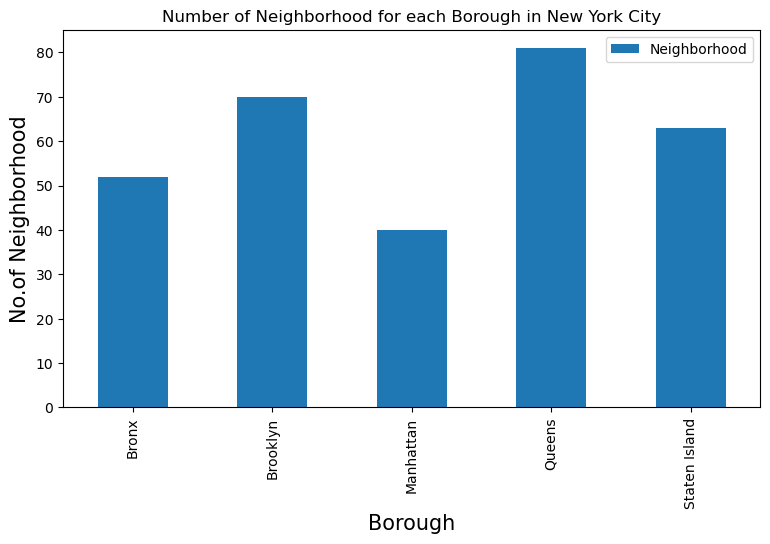

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

### Lets collect Indian resturants for each neighborhood.

In [11]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:1
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [12]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [13]:
indian_rest_ny.shape

(144, 4)

### From the above result, we see that there are 144 Indian Resturants across New York City.

### Create a bar plot to show Number of Indian Resturants for each Borough in New York City.

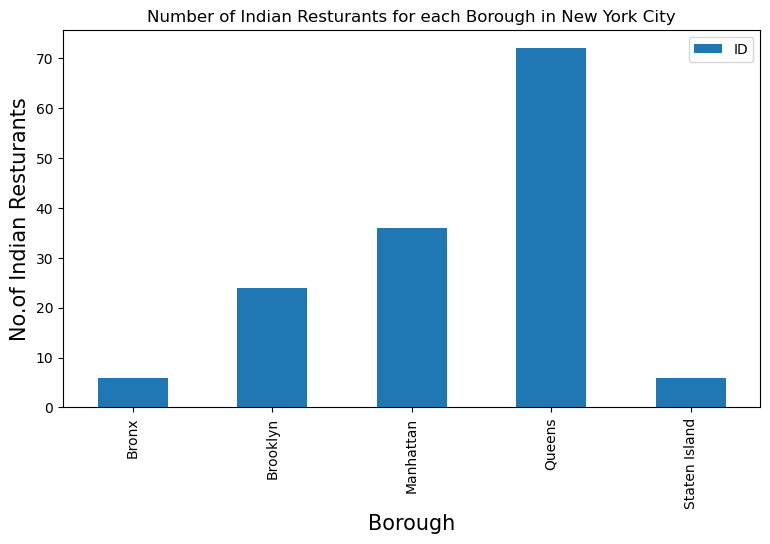

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of Indian resturants.

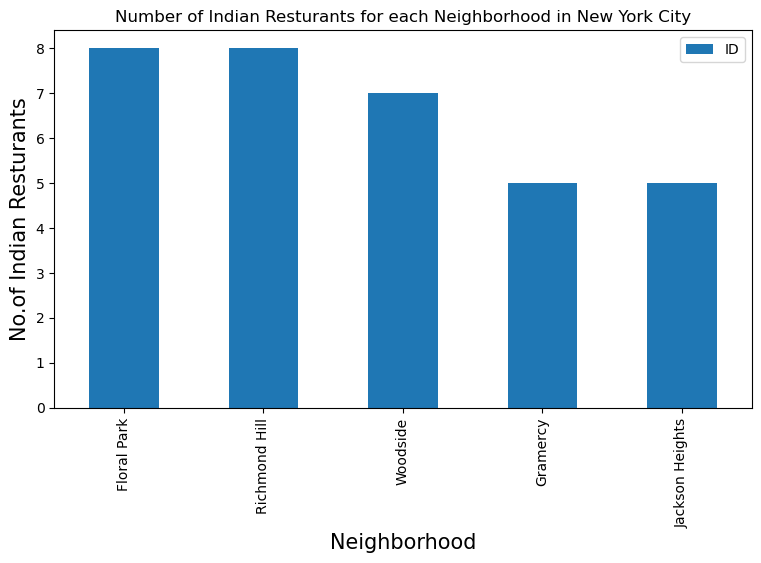

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [16]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
102,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
103,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
104,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
105,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
106,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
107,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
108,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
109,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [17]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Richmond Hill']

,Borough,Neighborhood,ID,Name
72,Queens,Richmond Hill,4b522029f964a520f26927e3,Sohna Punjab
73,Queens,Richmond Hill,5782c9ce498edde587f5aa14,Tikka Indian Grill
74,Queens,Richmond Hill,4f1b77d7e4b044fd359e6d21,India Cafe
75,Queens,Richmond Hill,4bb2bc48a32876b02e0b01fe,Tandoori Hut
76,Queens,Richmond Hill,4adbaef0f964a520ff2921e3,Punjabi Kabab House
77,Queens,Richmond Hill,4babc24ef964a5200ac73ae3,Royal India Palace
78,Queens,Richmond Hill,4edfae15d3e36374e25707a0,Punjabi Virsa Indian Restaurant
79,Queens,Richmond Hill,57d9e9a1498e545076560fef,Punjabi Diner


### We can see that, Floral Park and Richmond Hill in Queens have the highest number of Indian Resturants with a total count of 8 each.

### Get the ranking of each resturant for further analysis

In [22]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 4c0448d9310fc9b6bf1dc761
( 1 / 144 ) processed
No data available for id= 4c194631838020a13e78e561
( 2 / 144 ) processed
No data available for id= 4c04544df423a593ac83d116
( 3 / 144 ) processed
No data available for id= 551b7f75498e86c00a0ed2e1
( 4 / 144 ) processed
No data available for id= 4c194631838020a13e78e561
( 5 / 144 ) processed
No data available for id= 4b5a4dc8f964a520a2bb28e3
( 6 / 144 ) processed
No data available for id= 545835a1498e820edc6f636f
( 7 / 144 ) processed
No data available for id= 4af0d31bf964a5207ddf21e3
( 8 / 144 ) processed
No data available for id= 52213c4211d295d4c57a607c
( 9 / 144 ) processed
No data available for id= 564d283d498e6e851df79d87
( 10 / 144 ) processed
No data available for id= 512a9ea9e4b004fb8eeb84e5
( 11 / 144 ) processed
No data available for id= 4db0f4371e729fcc56497f20
( 12 / 144 ) processed
No data available for id= 4b718914f964a520c04b2de3
( 13 / 144 ) processed
No data available for id= 52f18573498ec2c34e830

No data available for id= 4c434b2bd691c9b6ef8f8f0a
( 112 / 144 ) processed
No data available for id= 4c66f1ac8e9120a1b266d964
( 113 / 144 ) processed
No data available for id= 4b1301c4f964a5208a9223e3
( 114 / 144 ) processed
No data available for id= 5623f6f9498e5a44a08bfae8
( 115 / 144 ) processed
No data available for id= 4dc0aaedae606fe8b71c226b
( 116 / 144 ) processed
No data available for id= 4b9be038f964a520393036e3
( 117 / 144 ) processed
No data available for id= 4be74a502468c928505a0243
( 118 / 144 ) processed
No data available for id= 4b9be038f964a520393036e3
( 119 / 144 ) processed
No data available for id= 4db0f4371e729fcc56497f20
( 120 / 144 ) processed
No data available for id= 519ff6c8498e1300ddcbd45c
( 121 / 144 ) processed
No data available for id= 4b65f2e3f964a5206e0a2be3
( 122 / 144 ) processed
No data available for id= 4be74a502468c928505a0243
( 123 / 144 ) processed
No data available for id= 56ed855a498ef3bb022352c3
( 124 / 144 ) processed
No data available for id=

In [ ]:
indian_rest_stats_ny.head()

In [ ]:
indian_rest_stats_ny.shape

In [ ]:
indian_rest_ny.shape

Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.